<a href="https://colab.research.google.com/github/itsSalah/AI-Health-Project/blob/main/Breast_Cancer_AI_Salahddin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
#Importing all the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [93]:
df = pd.read_csv('data.csv')

Data Cleaning

In [94]:
df.head()

id diagnosis  ...  fractal_dimension_worst  Unnamed: 32
0    842302         M  ...                  0.11890          NaN
1    842517         M  ...                  0.08902          NaN
2  84300903         M  ...                  0.08758          NaN
3  84348301         M  ...                  0.17300          NaN
4  84358402         M  ...                  0.07678          NaN

[5 rows x 33 columns]

In [95]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [96]:
#Not useful for the model
df = df.drop(columns=['id','Unnamed: 32'])

In [97]:
df.isnull().sum().sum()

0

In [98]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [99]:
#Encoding categorical variable into labels
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

Analyse the data

In [101]:
df.describe()

diagnosis  radius_mean  ...  symmetry_worst  fractal_dimension_worst
count  569.000000   569.000000  ...      569.000000               569.000000
mean     0.372583    14.127292  ...        0.290076                 0.083946
std      0.483918     3.524049  ...        0.061867                 0.018061
min      0.000000     6.981000  ...        0.156500                 0.055040
25%      0.000000    11.700000  ...        0.250400                 0.071460
50%      0.000000    13.370000  ...        0.282200                 0.080040
75%      1.000000    15.780000  ...        0.317900                 0.092080
max      1.000000    28.110000  ...        0.663800                 0.207500

[8 rows x 31 columns]

In [102]:
print(df.shape)
print()
df.columns

(569, 31)



Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

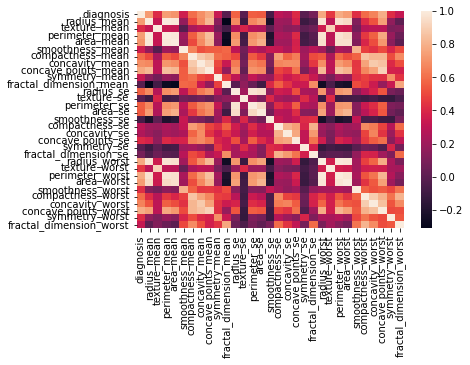

In [103]:
#We can see a high correlation between the worst measures and the mean of the measures.
#We will analyse them in greater details.
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [104]:
#To plot these measures separately we isolate them.
columns_mean = ['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean',
                'symmetry_mean','fractal_dimension_mean']
columns_worse = ['diagnosis','radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst','concave points_worst',
                'symmetry_worst','fractal_dimension_worst']

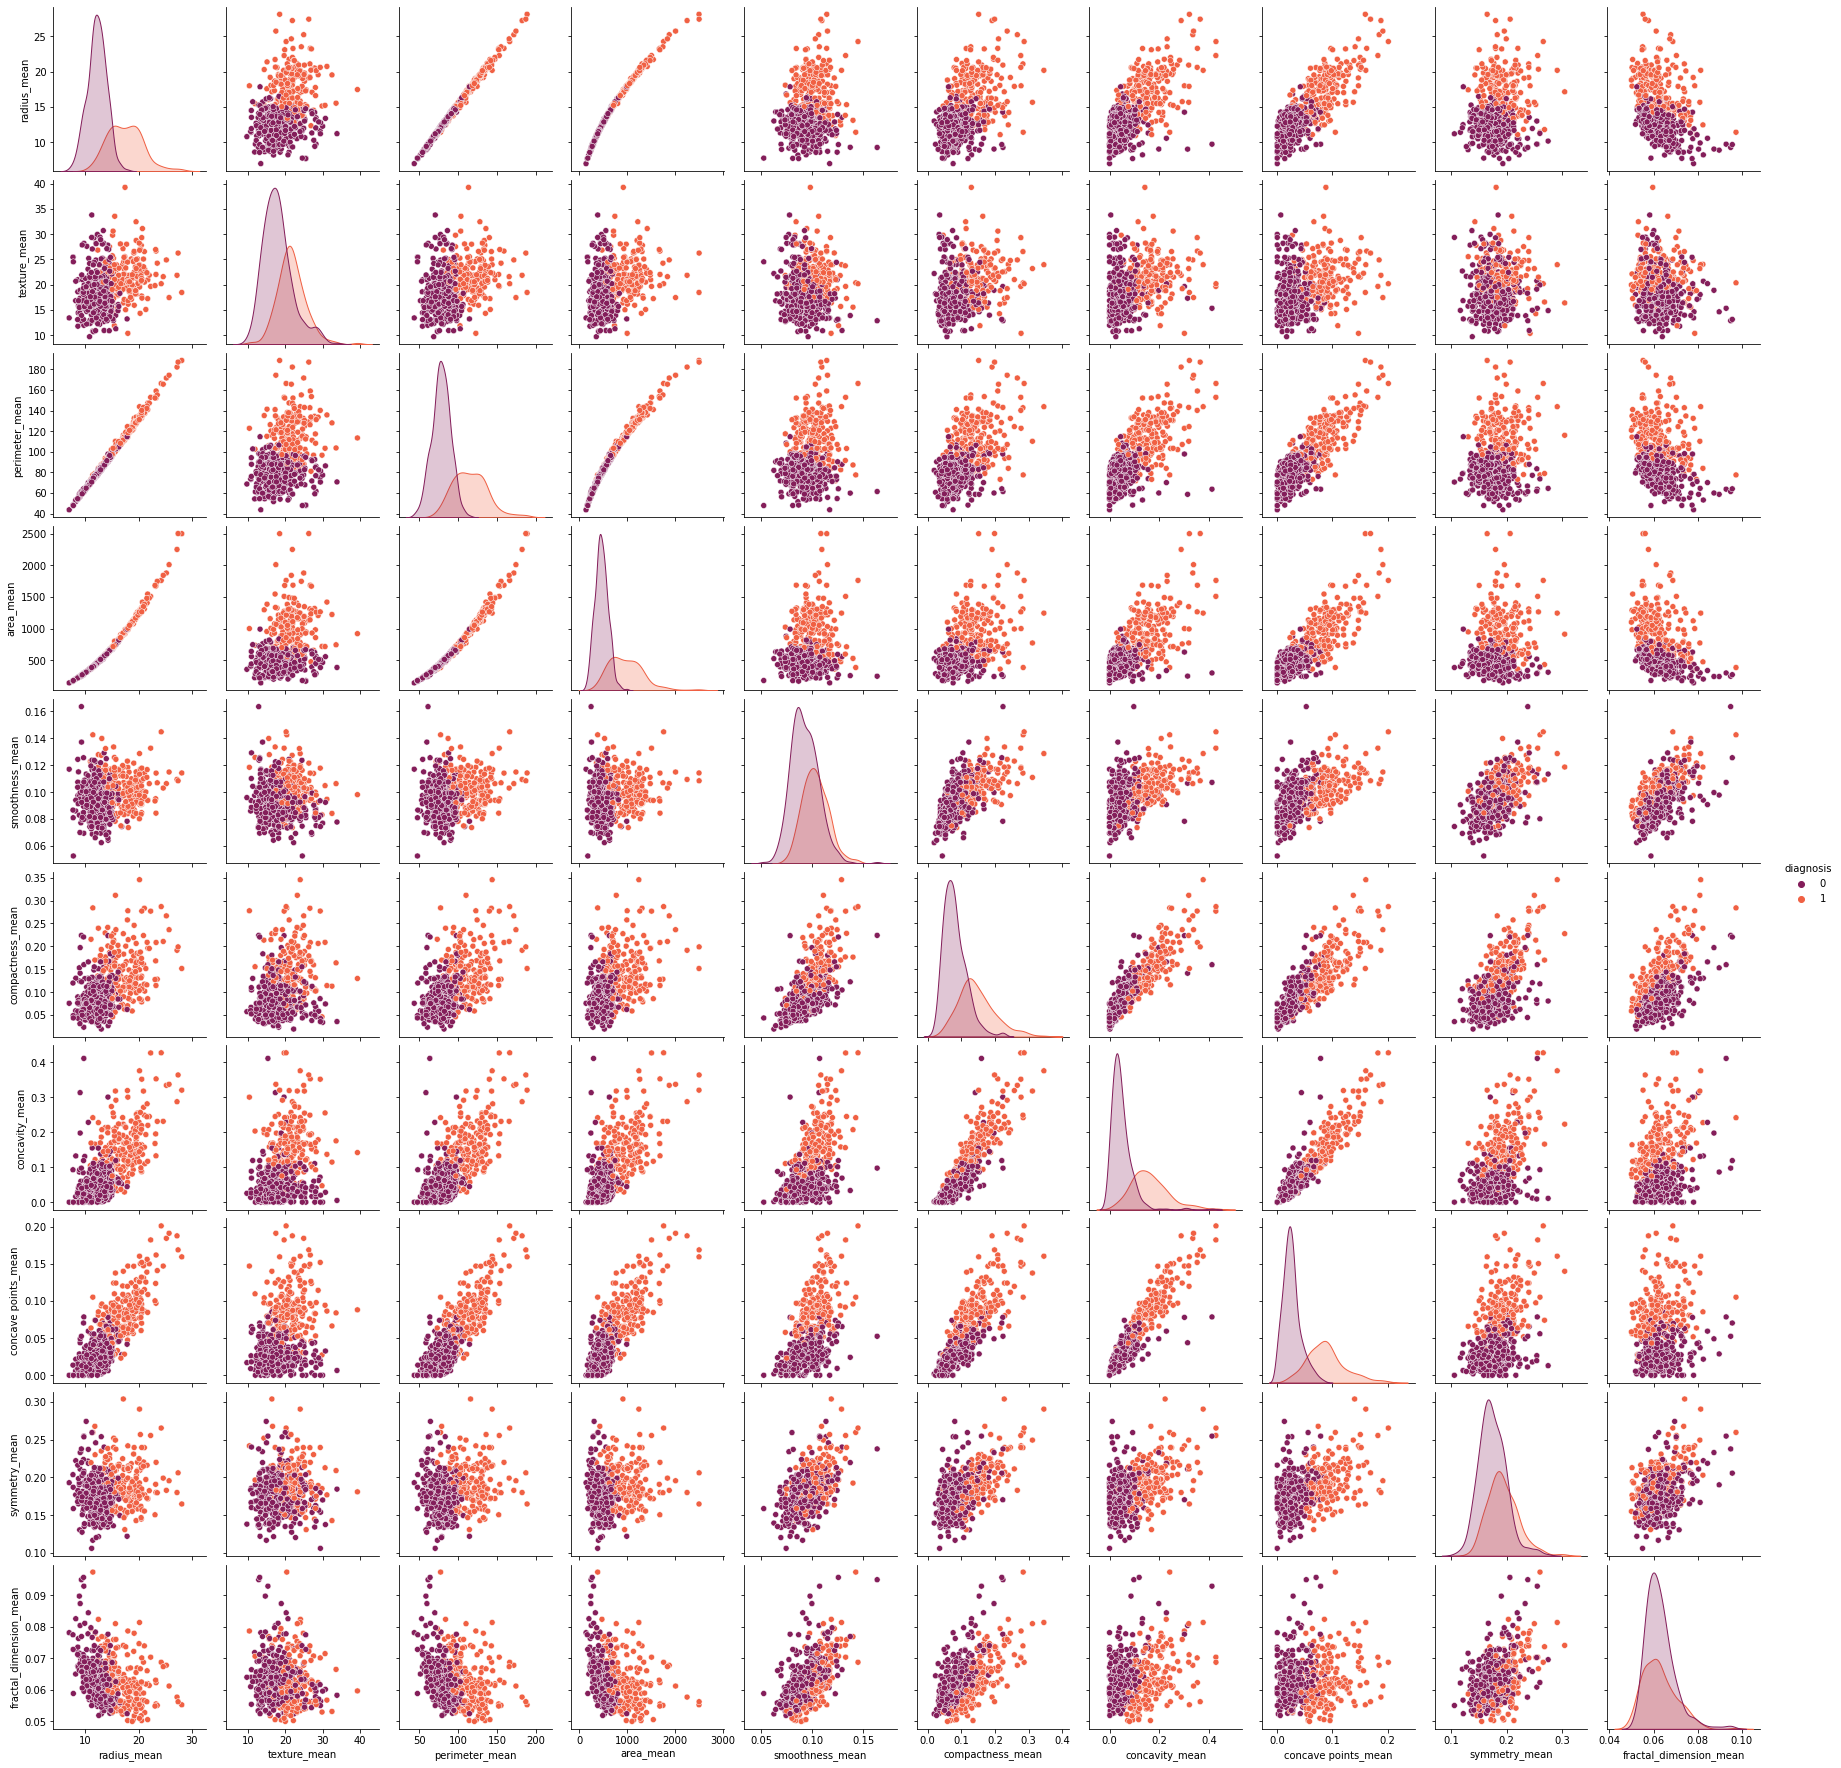

In [105]:
sns.pairplot(df[columns_mean],hue = 'diagnosis', palette='rocket')

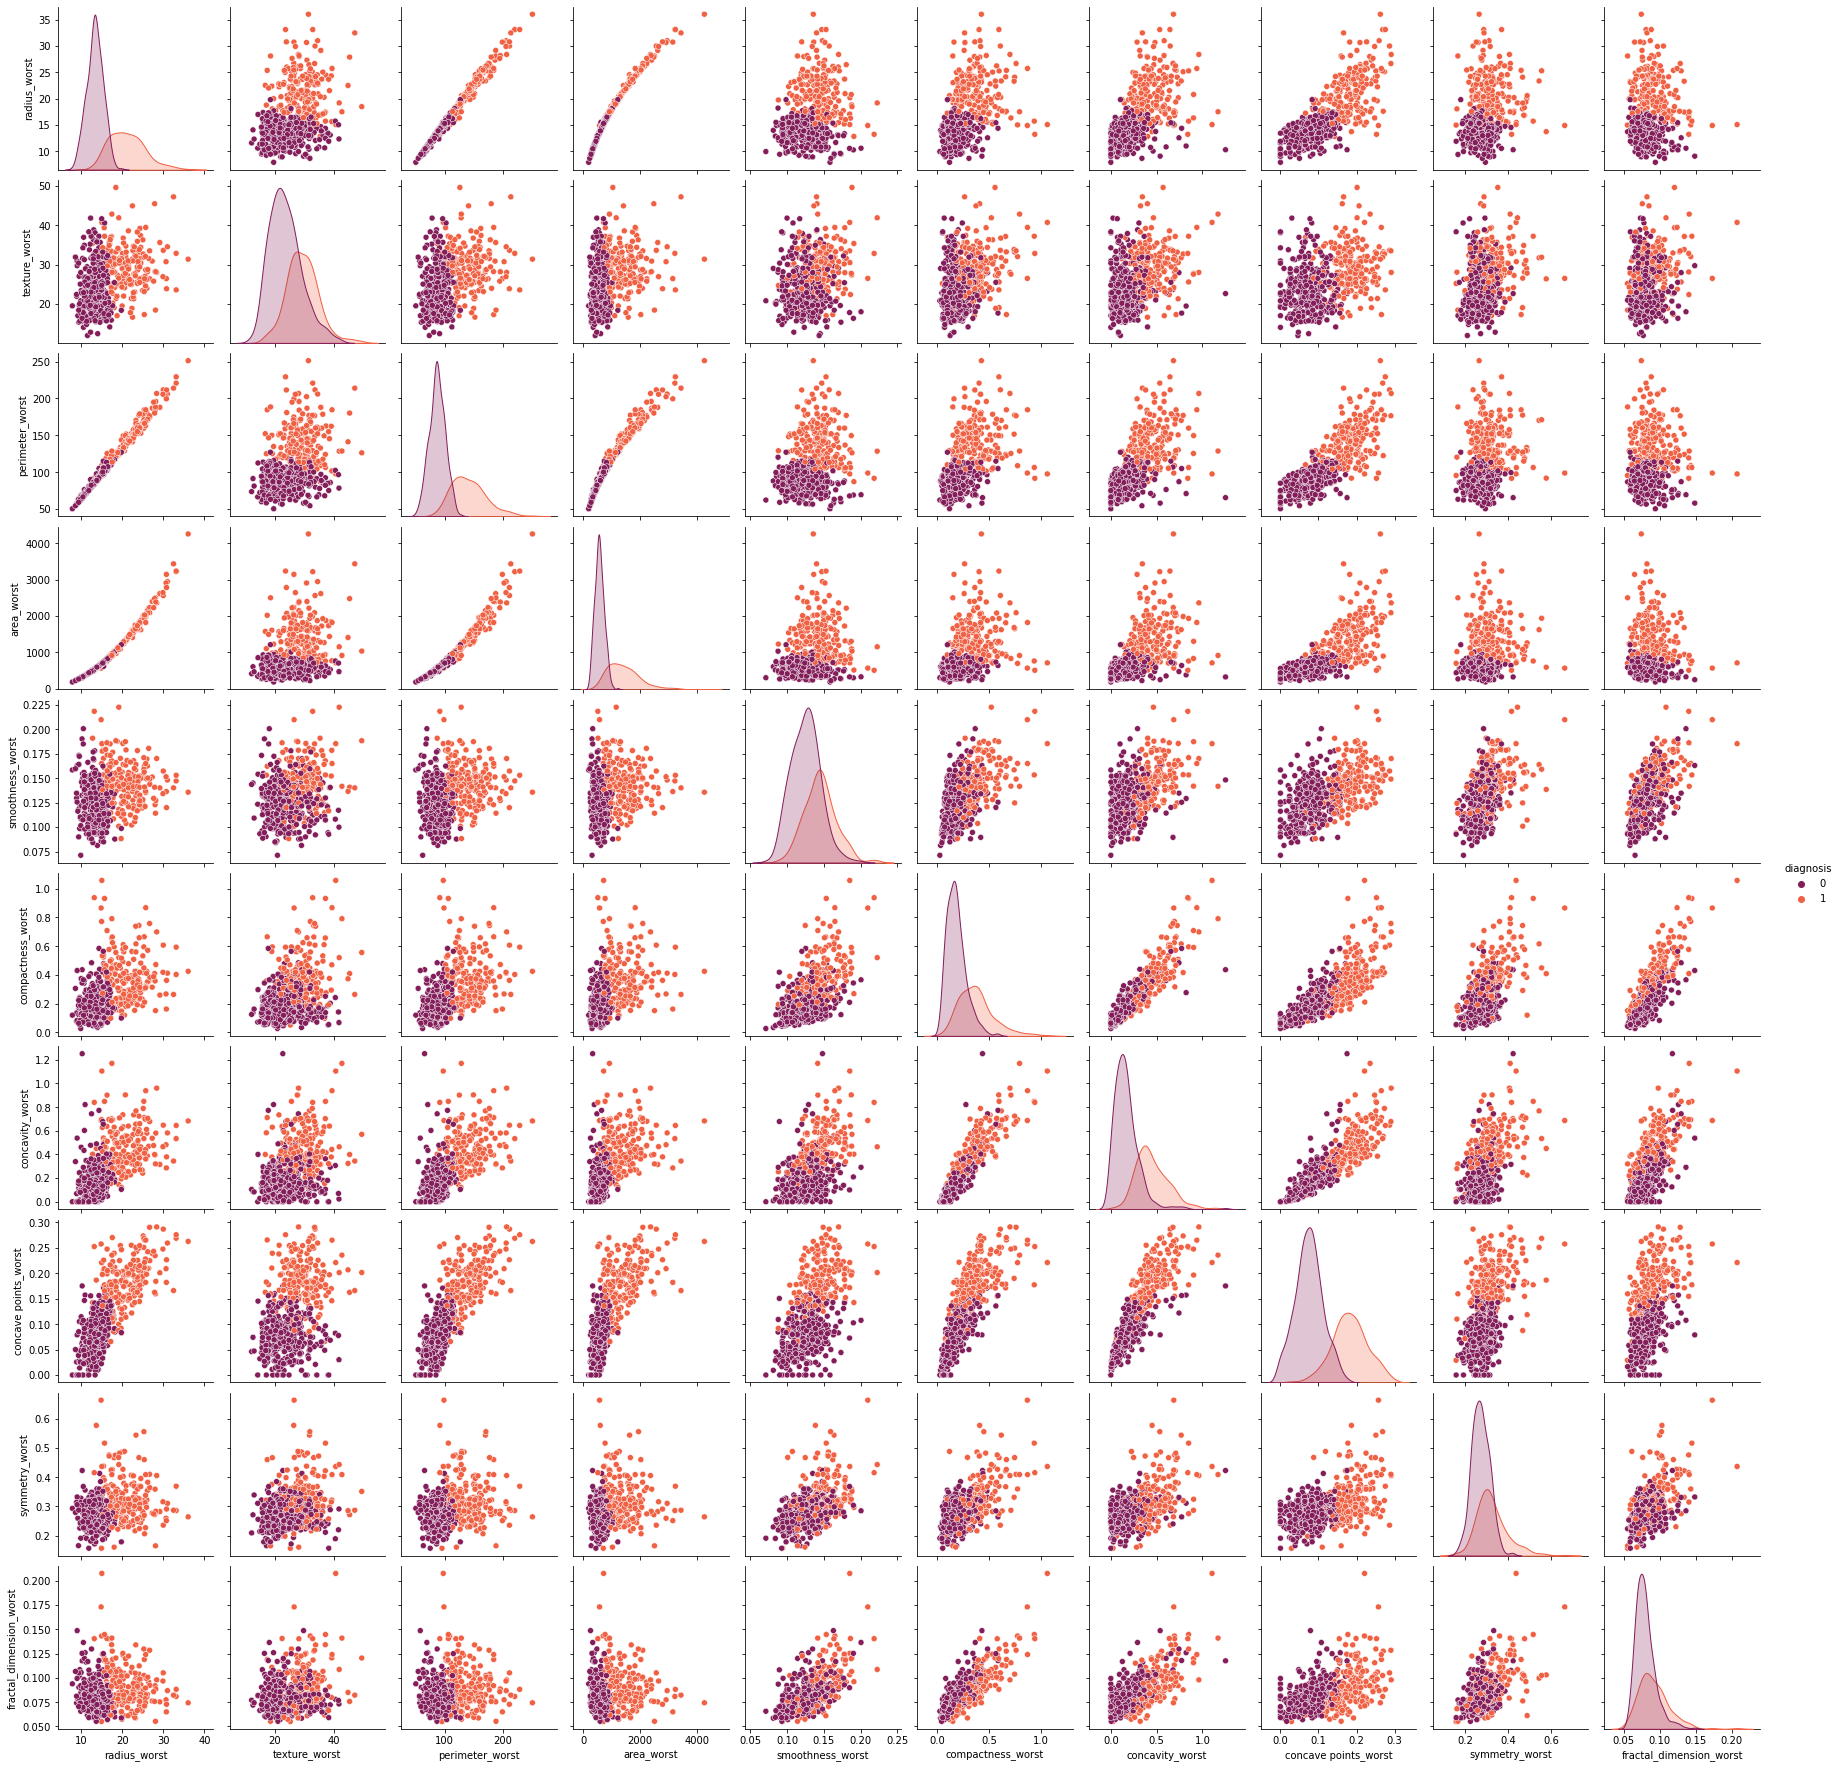

In [106]:
sns.pairplot(df[columns_worse],hue = 'diagnosis', palette='rocket')

# Splitting up the data and feature scaling (Model Preprocessing)

In [107]:
#We will evaluate the models on all our features, then on only the means, then on the means + standard error, etc.
X = df.iloc[:,1:]
X_mean_nose = df.iloc[:,1:11]
X_mean_se = df.iloc[:,1:21]
X_worst_nose = df.iloc[:,21:]
X_worst_se = df.iloc[:,11:]
y = df.iloc[:,0:1]

In [108]:
#Split up the training and test set for all the categories
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
X_train_mean_nose, X_test_mean_nose, y_train_mean_nose, y_test_mean_nose = train_test_split(X_mean_nose, y, test_size = 0.25, random_state = 1)
X_train_mean_se, X_test_mean_se, y_train_mean_se, y_test_mean_se = train_test_split(X_mean_se, y, test_size = 0.25, random_state = 1)
X_train_worst_nose, X_test_worst_nose, y_train_worst_nose, y_test_worst_nose = train_test_split(X_worst_nose, y, test_size = 0.25, random_state = 1)
X_train_worst_se, X_test_worst_se, y_train_worst_se, y_test_worst_se = train_test_split(X_worst_se, y, test_size = 0.25, random_state = 1)

In [109]:
#We will apply feature scaling on all the splits, fitting the scaler on the training set then apply it on the test set successively to 
#prevent data leakage from the test set to the training set.
sc_X = StandardScaler()
sc_X_mean_nose = StandardScaler()
sc_X_mean_se = StandardScaler()
sc_X_worst_nose = StandardScaler()
sc_X_worst_se = StandardScaler()

X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

X_train_mean_nose = sc_X_mean_nose.fit_transform(X_train_mean_nose)
X_test_mean_nose = sc_X_mean_nose.transform(X_test_mean_nose)

X_train_mean_se = sc_X_mean_se.fit_transform(X_train_mean_se)
X_test_mean_se = sc_X_mean_se.transform(X_test_mean_se)

X_train_worst_nose = sc_X_worst_nose.fit_transform(X_train_worst_nose)
X_test_worst_nose = sc_X_worst_nose.transform(X_test_worst_nose)

X_train_worst_se = sc_X_worst_se.fit_transform(X_train_worst_se)
X_test_worst_se = sc_X_worst_se.transform(X_test_worst_se)

# Training the Classification AI on Various Models

We will be training a variety of models on our numerous training sets. We will be evaluatiing the accuracy of each model. We will select the best model and we will tune it using gridsearch.

## Logistic Regression

In [110]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

classifier_mean_nose = LogisticRegression(random_state = 0)
classifier_mean_nose.fit(X_train_mean_nose, y_train_mean_nose)

classifier_mean_se = LogisticRegression(random_state = 0)
classifier_mean_se.fit(X_train_mean_se, y_train_mean_se)

classifier_worst_nose = LogisticRegression(random_state = 0)
classifier_worst_nose.fit(X_train_worst_nose, y_train_worst_nose)

classifier_worst_se = LogisticRegression(random_state = 0)
classifier_worst_se.fit(X_train_worst_se, y_train_worst_se)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [111]:
y_pred = classifier.predict(X_test)
y_pred_mean_nose = classifier_mean_nose.predict(X_test_mean_nose)
y_pred_mean_se = classifier_mean_se.predict(X_test_mean_se)
y_pred_worst_nose = classifier_worst_nose.predict(X_test_worst_nose)
y_pred_worst_se = classifier_worst_se.predict(X_test_worst_se)

In [112]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies_mean_nose = cross_val_score(estimator = classifier_mean_nose, X = X_train_mean_nose, y = y_train_mean_nose, cv = 10)
accuracies_mean_se = cross_val_score(estimator = classifier_mean_se, X = X_train_mean_se, y = y_train_mean_se, cv = 10)
accuracies_worst_nose = cross_val_score(estimator = classifier_worst_nose, X = X_train_worst_nose, y = y_train_worst_nose, cv = 10)
accuracies_worst_se = cross_val_score(estimator = classifier_worst_se, X = X_train_worst_se, y = y_train_worst_se, cv = 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [113]:
print("k-Fold Cross Validation Results (All the Features)")
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print()
print("Confusion Matrix and Accuracy (All the Features)")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test, y_pred))
print()

print("k-Fold Cross Validation Results (With Means Only)")
print("Accuracy: {:.2f} %".format(accuracies_mean_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means Only)")
cm = confusion_matrix(y_test_mean_nose, y_pred_mean_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_nose, y_pred_mean_nose))
print()

print("k-Fold Cross Validation Results (With Means and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_mean_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_mean_se, y_pred_mean_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_se, y_pred_mean_se))
print()

print("k-Fold Cross Validation Results (With Worsts Only)")
print("Accuracy: {:.2f} %".format(accuracies_worst_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_worst_nose, y_pred_worst_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_nose, y_pred_worst_nose))
print()

print("k-Fold Cross Validation Results (With Worsts and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_worst_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Worsts and Standard Error)")
cm = confusion_matrix(y_test_worst_se, y_pred_worst_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_se, y_pred_worst_se))
print()

k-Fold Cross Validation Results (All the Features)
Accuracy: 96.96 %
Standard Deviation: 2.33 %

Confusion Matrix and Accuracy (All the Features)
[[87  1]
 [ 2 53]]
Accuracy on the test set:
0.9790209790209791

k-Fold Cross Validation Results (With Means Only)
Accuracy: 93.44 %
Standard Deviation: 2.70 %

Confusion Matrix and Accuracy (With Means Only)
[[85  3]
 [ 6 49]]
Accuracy on the test set:
0.9370629370629371

k-Fold Cross Validation Results (With Means and Standard Error)
Accuracy: 94.86 %
Standard Deviation: 3.08 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[86  2]
 [ 3 52]]
Accuracy on the test set:
0.965034965034965

k-Fold Cross Validation Results (With Worsts Only)
Accuracy: 97.67 %
Standard Deviation: 4.16 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[87  1]
 [ 3 52]]
Accuracy on the test set:
0.972027972027972

k-Fold Cross Validation Results (With Worsts and Standard Error)
Accuracy: 97.43 %
Standard Deviation: 3.02 %

Confusion 

The logistic Model with the best accuracy on predicting the results from the test set is the one that contains all the features. We select it as the best logistic model for now.

## K-Nearest Neighbors (K-NN)

In [114]:
classifier = KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
classifier.fit(X_train, y_train)

classifier_mean_nose = KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
classifier_mean_nose.fit(X_train_mean_nose, y_train_mean_nose)

classifier_mean_se = KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
classifier_mean_se.fit(X_train_mean_se, y_train_mean_se)

classifier_worst_nose = KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
classifier_worst_nose.fit(X_train_worst_nose, y_train_worst_nose)

classifier_worst_se = KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
classifier_worst_se.fit(X_train_worst_se, y_train_worst_se)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [115]:
y_pred = classifier.predict(X_test)
y_pred_mean_nose = classifier_mean_nose.predict(X_test_mean_nose)
y_pred_mean_se = classifier_mean_se.predict(X_test_mean_se)
y_pred_worst_nose = classifier_worst_nose.predict(X_test_worst_nose)
y_pred_worst_se = classifier_worst_se.predict(X_test_worst_se)

In [116]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies_mean_nose = cross_val_score(estimator = classifier_mean_nose, X = X_train_mean_nose, y = y_train_mean_nose, cv = 10)
accuracies_mean_se = cross_val_score(estimator = classifier_mean_se, X = X_train_mean_se, y = y_train_mean_se, cv = 10)
accuracies_worst_nose = cross_val_score(estimator = classifier_worst_nose, X = X_train_worst_nose, y = y_train_worst_nose, cv = 10)
accuracies_worst_se = cross_val_score(estimator = classifier_worst_se, X = X_train_worst_se, y = y_train_worst_se, cv = 10)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

In [117]:
print("k-Fold Cross Validation Results (All the Features)")
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print()
print("Confusion Matrix and Accuracy (All the Features)")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test, y_pred))
print()

print("k-Fold Cross Validation Results (With Means Only)")
print("Accuracy: {:.2f} %".format(accuracies_mean_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means Only)")
cm = confusion_matrix(y_test_mean_nose, y_pred_mean_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_nose, y_pred_mean_nose))
print()

print("k-Fold Cross Validation Results (With Means and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_mean_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_mean_se, y_pred_mean_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_se, y_pred_mean_se))
print()

print("k-Fold Cross Validation Results (With Worsts Only)")
print("Accuracy: {:.2f} %".format(accuracies_worst_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_worst_nose, y_pred_worst_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_nose, y_pred_worst_nose))
print()

print("k-Fold Cross Validation Results (With Worsts and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_worst_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Worsts and Standard Error)")
cm = confusion_matrix(y_test_worst_se, y_pred_worst_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_se, y_pred_worst_se))
print()

k-Fold Cross Validation Results (All the Features)
Accuracy: 96.73 %
Standard Deviation: 2.37 %

Confusion Matrix and Accuracy (All the Features)
[[87  1]
 [ 6 49]]
Accuracy on the test set:
0.951048951048951

k-Fold Cross Validation Results (With Means Only)
Accuracy: 94.15 %
Standard Deviation: 3.63 %

Confusion Matrix and Accuracy (With Means Only)
[[86  2]
 [ 4 51]]
Accuracy on the test set:
0.958041958041958

k-Fold Cross Validation Results (With Means and Standard Error)
Accuracy: 96.25 %
Standard Deviation: 1.53 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[84  4]
 [ 5 50]]
Accuracy on the test set:
0.9370629370629371

k-Fold Cross Validation Results (With Worsts Only)
Accuracy: 97.43 %
Standard Deviation: 2.64 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[85  3]
 [ 4 51]]
Accuracy on the test set:
0.951048951048951

k-Fold Cross Validation Results (With Worsts and Standard Error)
Accuracy: 95.56 %
Standard Deviation: 4.58 %

Confusion M

Without tuning, the K-NN model doesn't perform as well as the logistic model. Therefore, we will eliminate it.

## Kernel Support Vector Machine (SVM))

In [118]:
classifier = SVC(kernel='rbf',random_state = 0)
classifier.fit(X_train, y_train)

classifier_mean_nose = SVC(kernel='rbf',random_state = 0)
classifier_mean_nose.fit(X_train_mean_nose, y_train_mean_nose)

classifier_mean_se = SVC(kernel='rbf',random_state = 0)
classifier_mean_se.fit(X_train_mean_se, y_train_mean_se)

classifier_worst_nose = SVC(kernel='rbf',random_state = 0)
classifier_worst_nose.fit(X_train_worst_nose, y_train_worst_nose)

classifier_worst_se = SVC(kernel='rbf',random_state = 0)
classifier_worst_se.fit(X_train_worst_se, y_train_worst_se)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [119]:
y_pred = classifier.predict(X_test)
y_pred_mean_nose = classifier_mean_nose.predict(X_test_mean_nose)
y_pred_mean_se = classifier_mean_se.predict(X_test_mean_se)
y_pred_worst_nose = classifier_worst_nose.predict(X_test_worst_nose)
y_pred_worst_se = classifier_worst_se.predict(X_test_worst_se)

In [120]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies_mean_nose = cross_val_score(estimator = classifier_mean_nose, X = X_train_mean_nose, y = y_train_mean_nose, cv = 10)
accuracies_mean_se = cross_val_score(estimator = classifier_mean_se, X = X_train_mean_se, y = y_train_mean_se, cv = 10)
accuracies_worst_nose = cross_val_score(estimator = classifier_worst_nose, X = X_train_worst_nose, y = y_train_worst_nose, cv = 10)
accuracies_worst_se = cross_val_score(estimator = classifier_worst_se, X = X_train_worst_se, y = y_train_worst_se, cv = 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [121]:
print("k-Fold Cross Validation Results (All the Features)")
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print()
print("Confusion Matrix and Accuracy (All the Features)")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test, y_pred))
print()

print("k-Fold Cross Validation Results (With Means Only)")
print("Accuracy: {:.2f} %".format(accuracies_mean_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means Only)")
cm = confusion_matrix(y_test_mean_nose, y_pred_mean_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_nose, y_pred_mean_nose))
print()

print("k-Fold Cross Validation Results (With Means and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_mean_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_mean_se, y_pred_mean_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_se, y_pred_mean_se))
print()

print("k-Fold Cross Validation Results (With Worsts Only)")
print("Accuracy: {:.2f} %".format(accuracies_worst_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_worst_nose, y_pred_worst_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_nose, y_pred_worst_nose))
print()

print("k-Fold Cross Validation Results (With Worsts and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_worst_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Worsts and Standard Error)")
cm = confusion_matrix(y_test_worst_se, y_pred_worst_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_se, y_pred_worst_se))
print()

k-Fold Cross Validation Results (All the Features)
Accuracy: 96.72 %
Standard Deviation: 3.49 %

Confusion Matrix and Accuracy (All the Features)
[[86  2]
 [ 3 52]]
Accuracy on the test set:
0.965034965034965

k-Fold Cross Validation Results (With Means Only)
Accuracy: 95.31 %
Standard Deviation: 2.95 %

Confusion Matrix and Accuracy (With Means Only)
[[85  3]
 [ 6 49]]
Accuracy on the test set:
0.9370629370629371

k-Fold Cross Validation Results (With Means and Standard Error)
Accuracy: 93.91 %
Standard Deviation: 2.36 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[86  2]
 [ 4 51]]
Accuracy on the test set:
0.958041958041958

k-Fold Cross Validation Results (With Worsts Only)
Accuracy: 97.20 %
Standard Deviation: 4.13 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[86  2]
 [ 5 50]]
Accuracy on the test set:
0.951048951048951

k-Fold Cross Validation Results (With Worsts and Standard Error)
Accuracy: 96.26 %
Standard Deviation: 4.19 %

Confusion M

The model is not perfoming better than the current best model (without tuning). We eliminate the SVM model.

## Naive Bayes

In [122]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

classifier_mean_nose = GaussianNB()
classifier_mean_nose.fit(X_train_mean_nose, y_train_mean_nose)

classifier_mean_se = GaussianNB()
classifier_mean_se.fit(X_train_mean_se, y_train_mean_se)

classifier_worst_nose = GaussianNB()
classifier_worst_nose.fit(X_train_worst_nose, y_train_worst_nose)

classifier_worst_se = GaussianNB()
classifier_worst_se.fit(X_train_worst_se, y_train_worst_se)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

GaussianNB(priors=None, var_smoothing=1e-09)

In [123]:
y_pred = classifier.predict(X_test)
y_pred_mean_nose = classifier_mean_nose.predict(X_test_mean_nose)
y_pred_mean_se = classifier_mean_se.predict(X_test_mean_se)
y_pred_worst_nose = classifier_worst_nose.predict(X_test_worst_nose)
y_pred_worst_se = classifier_worst_se.predict(X_test_worst_se)

In [124]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies_mean_nose = cross_val_score(estimator = classifier_mean_nose, X = X_train_mean_nose, y = y_train_mean_nose, cv = 10)
accuracies_mean_se = cross_val_score(estimator = classifier_mean_se, X = X_train_mean_se, y = y_train_mean_se, cv = 10)
accuracies_worst_nose = cross_val_score(estimator = classifier_worst_nose, X = X_train_worst_nose, y = y_train_worst_nose, cv = 10)
accuracies_worst_se = cross_val_score(estimator = classifier_worst_se, X = X_train_worst_se, y = y_train_worst_se, cv = 10)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

In [125]:
print("k-Fold Cross Validation Results (All the Features)")
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print()
print("Confusion Matrix and Accuracy (All the Features)")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test, y_pred))
print()

print("k-Fold Cross Validation Results (With Means Only)")
print("Accuracy: {:.2f} %".format(accuracies_mean_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means Only)")
cm = confusion_matrix(y_test_mean_nose, y_pred_mean_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_nose, y_pred_mean_nose))
print()

print("k-Fold Cross Validation Results (With Means and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_mean_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_mean_se, y_pred_mean_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_se, y_pred_mean_se))
print()

print("k-Fold Cross Validation Results (With Worsts Only)")
print("Accuracy: {:.2f} %".format(accuracies_worst_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_worst_nose, y_pred_worst_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_nose, y_pred_worst_nose))
print()

print("k-Fold Cross Validation Results (With Worsts and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_worst_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Worsts and Standard Error)")
cm = confusion_matrix(y_test_worst_se, y_pred_worst_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_se, y_pred_worst_se))
print()

k-Fold Cross Validation Results (All the Features)
Accuracy: 93.22 %
Standard Deviation: 4.20 %

Confusion Matrix and Accuracy (All the Features)
[[85  3]
 [ 5 50]]
Accuracy on the test set:
0.9440559440559441

k-Fold Cross Validation Results (With Means Only)
Accuracy: 91.55 %
Standard Deviation: 3.00 %

Confusion Matrix and Accuracy (With Means Only)
[[82  6]
 [ 8 47]]
Accuracy on the test set:
0.9020979020979021

k-Fold Cross Validation Results (With Means and Standard Error)
Accuracy: 90.62 %
Standard Deviation: 2.93 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[86  2]
 [ 8 47]]
Accuracy on the test set:
0.9300699300699301

k-Fold Cross Validation Results (With Worsts Only)
Accuracy: 95.31 %
Standard Deviation: 3.29 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[84  4]
 [ 6 49]]
Accuracy on the test set:
0.9300699300699301

k-Fold Cross Validation Results (With Worsts and Standard Error)
Accuracy: 93.92 %
Standard Deviation: 4.04 %

Confusio

The model is not perfoming better than the current best model. We eliminate the Naive Bayes model.

## Decision Tree

In [126]:
classifier = DecisionTreeClassifier(criterion='entropy',random_state=0)
classifier.fit(X_train, y_train)

classifier_mean_nose = DecisionTreeClassifier(criterion='entropy',random_state=0)
classifier_mean_nose.fit(X_train_mean_nose, y_train_mean_nose)

classifier_mean_se = DecisionTreeClassifier(criterion='entropy',random_state=0)
classifier_mean_se.fit(X_train_mean_se, y_train_mean_se)

classifier_worst_nose = DecisionTreeClassifier(criterion='entropy',random_state=0)
classifier_worst_nose.fit(X_train_worst_nose, y_train_worst_nose)

classifier_worst_se = DecisionTreeClassifier(criterion='entropy',random_state=0)
classifier_worst_se.fit(X_train_worst_se, y_train_worst_se)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [127]:
y_pred = classifier.predict(X_test)
y_pred_mean_nose = classifier_mean_nose.predict(X_test_mean_nose)
y_pred_mean_se = classifier_mean_se.predict(X_test_mean_se)
y_pred_worst_nose = classifier_worst_nose.predict(X_test_worst_nose)
y_pred_worst_se = classifier_worst_se.predict(X_test_worst_se)

In [128]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies_mean_nose = cross_val_score(estimator = classifier_mean_nose, X = X_train_mean_nose, y = y_train_mean_nose, cv = 10)
accuracies_mean_se = cross_val_score(estimator = classifier_mean_se, X = X_train_mean_se, y = y_train_mean_se, cv = 10)
accuracies_worst_nose = cross_val_score(estimator = classifier_worst_nose, X = X_train_worst_nose, y = y_train_worst_nose, cv = 10)
accuracies_worst_se = cross_val_score(estimator = classifier_worst_se, X = X_train_worst_se, y = y_train_worst_se, cv = 10)

In [129]:
print("k-Fold Cross Validation Results (All the Features)")
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print()
print("Confusion Matrix and Accuracy (All the Features)")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test, y_pred))
print()

print("k-Fold Cross Validation Results (With Means Only)")
print("Accuracy: {:.2f} %".format(accuracies_mean_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means Only)")
cm = confusion_matrix(y_test_mean_nose, y_pred_mean_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_nose, y_pred_mean_nose))
print()

print("k-Fold Cross Validation Results (With Means and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_mean_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_mean_se, y_pred_mean_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_se, y_pred_mean_se))
print()

print("k-Fold Cross Validation Results (With Worsts Only)")
print("Accuracy: {:.2f} %".format(accuracies_worst_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_worst_nose, y_pred_worst_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_nose, y_pred_worst_nose))
print()

print("k-Fold Cross Validation Results (With Worsts and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_worst_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Worsts and Standard Error)")
cm = confusion_matrix(y_test_worst_se, y_pred_worst_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_se, y_pred_worst_se))
print()

k-Fold Cross Validation Results (All the Features)
Accuracy: 94.62 %
Standard Deviation: 3.76 %

Confusion Matrix and Accuracy (All the Features)
[[84  4]
 [ 5 50]]
Accuracy on the test set:
0.9370629370629371

k-Fold Cross Validation Results (With Means Only)
Accuracy: 92.02 %
Standard Deviation: 3.01 %

Confusion Matrix and Accuracy (With Means Only)
[[82  6]
 [ 7 48]]
Accuracy on the test set:
0.9090909090909091

k-Fold Cross Validation Results (With Means and Standard Error)
Accuracy: 91.31 %
Standard Deviation: 3.21 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[83  5]
 [ 3 52]]
Accuracy on the test set:
0.9440559440559441

k-Fold Cross Validation Results (With Worsts Only)
Accuracy: 95.08 %
Standard Deviation: 3.82 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[83  5]
 [ 5 50]]
Accuracy on the test set:
0.9300699300699301

k-Fold Cross Validation Results (With Worsts and Standard Error)
Accuracy: 94.39 %
Standard Deviation: 4.05 %

Confusio

The model is not perfoming better than the current best model. We eliminate the Decision Tree model.

## Random Forest Classification

In [130]:
classifier = RandomForestClassifier(criterion='gini',n_estimators=10,random_state=0)
classifier.fit(X_train, y_train)

classifier_mean_nose = RandomForestClassifier(criterion='gini',n_estimators=10,random_state=0)
classifier_mean_nose.fit(X_train_mean_nose, y_train_mean_nose)

classifier_mean_se = RandomForestClassifier(criterion='gini',n_estimators=10,random_state=0)
classifier_mean_se.fit(X_train_mean_se, y_train_mean_se)

classifier_worst_nose = RandomForestClassifier(criterion='gini',n_estimators=10,random_state=0)
classifier_worst_nose.fit(X_train_worst_nose, y_train_worst_nose)

classifier_worst_se = RandomForestClassifier(criterion='gini',n_estimators=10,random_state=0)
classifier_worst_se.fit(X_train_worst_se, y_train_worst_se)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_laun

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [131]:
y_pred = classifier.predict(X_test)
y_pred_mean_nose = classifier_mean_nose.predict(X_test_mean_nose)
y_pred_mean_se = classifier_mean_se.predict(X_test_mean_se)
y_pred_worst_nose = classifier_worst_nose.predict(X_test_worst_nose)
y_pred_worst_se = classifier_worst_se.predict(X_test_worst_se)

In [132]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies_mean_nose = cross_val_score(estimator = classifier_mean_nose, X = X_train_mean_nose, y = y_train_mean_nose, cv = 10)
accuracies_mean_se = cross_val_score(estimator = classifier_mean_se, X = X_train_mean_se, y = y_train_mean_se, cv = 10)
accuracies_worst_nose = cross_val_score(estimator = classifier_worst_nose, X = X_train_worst_nose, y = y_train_worst_nose, cv = 10)
accuracies_worst_se = cross_val_score(estimator = classifier_worst_se, X = X_train_worst_se, y = y_train_worst_se, cv = 10)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

In [133]:
print("k-Fold Cross Validation Results (All the Features)")
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print()
print("Confusion Matrix and Accuracy (All the Features)")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test, y_pred))
print()

print("k-Fold Cross Validation Results (With Means Only)")
print("Accuracy: {:.2f} %".format(accuracies_mean_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means Only)")
cm = confusion_matrix(y_test_mean_nose, y_pred_mean_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_nose, y_pred_mean_nose))
print()

print("k-Fold Cross Validation Results (With Means and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_mean_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_mean_se, y_pred_mean_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_se, y_pred_mean_se))
print()

print("k-Fold Cross Validation Results (With Worsts Only)")
print("Accuracy: {:.2f} %".format(accuracies_worst_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_worst_nose, y_pred_worst_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_nose, y_pred_worst_nose))
print()

print("k-Fold Cross Validation Results (With Worsts and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_worst_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Worsts and Standard Error)")
cm = confusion_matrix(y_test_worst_se, y_pred_worst_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_se, y_pred_worst_se))
print()

k-Fold Cross Validation Results (All the Features)
Accuracy: 96.03 %
Standard Deviation: 2.34 %

Confusion Matrix and Accuracy (All the Features)
[[87  1]
 [ 7 48]]
Accuracy on the test set:
0.9440559440559441

k-Fold Cross Validation Results (With Means Only)
Accuracy: 93.21 %
Standard Deviation: 2.42 %

Confusion Matrix and Accuracy (With Means Only)
[[83  5]
 [ 7 48]]
Accuracy on the test set:
0.916083916083916

k-Fold Cross Validation Results (With Means and Standard Error)
Accuracy: 93.43 %
Standard Deviation: 2.54 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[84  4]
 [ 7 48]]
Accuracy on the test set:
0.9230769230769231

k-Fold Cross Validation Results (With Worsts Only)
Accuracy: 95.31 %
Standard Deviation: 2.96 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[86  2]
 [ 5 50]]
Accuracy on the test set:
0.951048951048951

k-Fold Cross Validation Results (With Worsts and Standard Error)
Accuracy: 93.69 %
Standard Deviation: 4.87 %

Confusion 

The model is not perfoming better than the current best model. We eliminate the Random Forest model.

## XGBoost

In [134]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

classifier_mean_nose = XGBClassifier()
classifier_mean_nose.fit(X_train_mean_nose, y_train_mean_nose)

classifier_mean_se = XGBClassifier()
classifier_mean_se.fit(X_train_mean_se, y_train_mean_se)

classifier_worst_nose = XGBClassifier()
classifier_worst_nose.fit(X_train_worst_nose, y_train_worst_nose)

classifier_worst_se = XGBClassifier()
classifier_worst_se.fit(X_train_worst_se, y_train_worst_se)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [135]:
y_pred = classifier.predict(X_test)
y_pred_mean_nose = classifier_mean_nose.predict(X_test_mean_nose)
y_pred_mean_se = classifier_mean_se.predict(X_test_mean_se)
y_pred_worst_nose = classifier_worst_nose.predict(X_test_worst_nose)
y_pred_worst_se = classifier_worst_se.predict(X_test_worst_se)

In [136]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies_mean_nose = cross_val_score(estimator = classifier_mean_nose, X = X_train_mean_nose, y = y_train_mean_nose, cv = 10)
accuracies_mean_se = cross_val_score(estimator = classifier_mean_se, X = X_train_mean_se, y = y_train_mean_se, cv = 10)
accuracies_worst_nose = cross_val_score(estimator = classifier_worst_nose, X = X_train_worst_nose, y = y_train_worst_nose, cv = 10)
accuracies_worst_se = cross_val_score(estimator = classifier_worst_se, X = X_train_worst_se, y = y_train_worst_se, cv = 10)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [137]:
print("k-Fold Cross Validation Results (All the Features)")
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print()
print("Confusion Matrix and Accuracy (All the Features)")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test, y_pred))
print()

print("k-Fold Cross Validation Results (With Means Only)")
print("Accuracy: {:.2f} %".format(accuracies_mean_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means Only)")
cm = confusion_matrix(y_test_mean_nose, y_pred_mean_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_nose, y_pred_mean_nose))
print()

print("k-Fold Cross Validation Results (With Means and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_mean_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_mean_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_mean_se, y_pred_mean_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_mean_se, y_pred_mean_se))
print()

print("k-Fold Cross Validation Results (With Worsts Only)")
print("Accuracy: {:.2f} %".format(accuracies_worst_nose.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_nose.std()*100))
print()
print("Confusion Matrix and Accuracy (With Means and Standard Error)")
cm = confusion_matrix(y_test_worst_nose, y_pred_worst_nose)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_nose, y_pred_worst_nose))
print()

print("k-Fold Cross Validation Results (With Worsts and Standard Error)")
print("Accuracy: {:.2f} %".format(accuracies_worst_se.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_worst_se.std()*100))
print()
print("Confusion Matrix and Accuracy (With Worsts and Standard Error)")
cm = confusion_matrix(y_test_worst_se, y_pred_worst_se)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test_worst_se, y_pred_worst_se))
print()

k-Fold Cross Validation Results (All the Features)
Accuracy: 96.01 %
Standard Deviation: 1.82 %

Confusion Matrix and Accuracy (All the Features)
[[86  2]
 [ 6 49]]
Accuracy on the test set:
0.9440559440559441

k-Fold Cross Validation Results (With Means Only)
Accuracy: 94.61 %
Standard Deviation: 1.81 %

Confusion Matrix and Accuracy (With Means Only)
[[84  4]
 [ 3 52]]
Accuracy on the test set:
0.951048951048951

k-Fold Cross Validation Results (With Means and Standard Error)
Accuracy: 94.13 %
Standard Deviation: 2.62 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[84  4]
 [ 3 52]]
Accuracy on the test set:
0.951048951048951

k-Fold Cross Validation Results (With Worsts Only)
Accuracy: 96.25 %
Standard Deviation: 3.16 %

Confusion Matrix and Accuracy (With Means and Standard Error)
[[85  3]
 [ 4 51]]
Accuracy on the test set:
0.951048951048951

k-Fold Cross Validation Results (With Worsts and Standard Error)
Accuracy: 95.31 %
Standard Deviation: 2.96 %

Confusion M

Surprisingly, the XGBoost model doesn't beat the logistic model on its predictions for the test set results. It's doing worse in the K-fold cross validation and the accuracy results.

# Tuning the best model

## Reload the best model (Logistic Classifier with all the features)

In [138]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Tuning with GridSearch

In [139]:
parameters = {'penalty': ['l1','l2', 'elasticnet'], 'C': [0.1,0.2,0.3,0.4,0.5], 'random_state':[0]}
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search.fit(X_train, y_train)
print("Best Accuracy: {:.2f} %".format(grid_search.best_score_*100))
print("Best Parameters:", grid_search.best_params_)

Best Accuracy: 97.66 %
Best Parameters: {'C': 0.4, 'penalty': 'l2', 'random_state': 0}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Training the logistic model with these hyperparameters

In [140]:
classifier_best = LogisticRegression(C=0.4,penalty='l2',random_state = 0)
classifier_best.fit(X_train, y_train)
y_pred = classifier_best.predict(X_test)
accuracies = cross_val_score(estimator = classifier_best, X = X_train, y = y_train, cv = 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

## Evaluating the final results

In [141]:
print("k-Fold Cross Validation Results (All the Features)")
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print()
print("Confusion Matrix and Accuracy (All the Features)")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy on the test set:")
print(accuracy_score(y_test, y_pred))
print()

k-Fold Cross Validation Results (All the Features)
Accuracy: 97.66 %
Standard Deviation: 2.55 %

Confusion Matrix and Accuracy (All the Features)
[[87  1]
 [ 4 51]]
Accuracy on the test set:
0.965034965034965



## Final Discussion

The final model selected performed well on the k-Fold Cross Validation test with an accuracy of 97.66% and a standard deviation of 2.55%. It performed sighly worse on the prediction for the test set compared to the undertuned model. We attribute this difference due to the randomness of the sample. 

With an overall accuracy of 96.5% on the test set, we can say that the model performs well. The model was able to detect 51 cancers out of 55. Therefore, 7.3% of the cancers went undetected by the model.

With more tuning of this and other models we could perform sighly better than in this case scenario. 

Next steps: Tune the model even more / Build a deep learning model to distinguish cancers from image detection.